In [1]:
# 数据读取
import numpy as np

label = ['a','e','g','i','l','n','o','r','t','u'] # 序号对应的标签

def data_read(filepath):
    data = np.loadtxt(filepath,dtype = np.uint8, delimiter = ',')

    # 划分数据和标签
    Y = data[:,0]
    X = data[:,1:]
    return X,Y

In [2]:
# 填充1以计算偏置值
def insert_bias(X):
    c = np.ones(X.shape[0]).transpose()
    X = np.insert(X,0,values=c,axis=1)#对原始数据加入一个全为1的列
    return  X

# 前向计算

In [16]:
# 线性层，x与w相乘,得到z
def linearForward(input, p):
    """
    :param input: input vector (column vector) WITH bias feature added
    :param p: parameter matrix (alpha/beta) WITH bias parameter added
    :return: output vector
    """
    z = input.dot(p)
    return z

# sigmoid激活函数
def sigmoidForward(z):
    """
    :param z: input vector WITH bias feature added
    """
#     a = 1/(1+np.exp(-z))

    a = np.array([])
    for i in range(len(z)):
        if z[i]>=0:      #对sigmoid函数的优化，避免了出现极大的数据溢出
            a = np.append(a,1.0/(1+np.exp(-z[i])))
        else:
            a = np.append(a,np.exp(z[i])/(1+np.exp(z[i])))
    return a

# softmax,得到概率分布
def softmaxForward(b):
    """
    :param b: input vector WITH bias feature added
    """
    y_hat = np.exp(b)/sum(np.exp(b))
    return y_hat

# 交叉熵损失函数
def crossEntropyForward(y, y_hat):
    """
    :param y: true label
    :param y_hat: vector of probabilistic distribution for predicted label
    :return: float
    """
    hot_y = np.zeros(10)
    hot_y[y] = 1 # 1-hot vector for true label
    
    # 交叉熵损失函数
    v = -hot_y*np.log(y_hat)
    loss = 0 
    for i in range(0,len(v)):
        loss += v[i]
    return loss


In [4]:
# 前向计算过程
def NNForward(x, y, alpha, beta):  
    """
    :param x: input data (column vector) WITH bias feature added
    :param y: input (true) labels
    :param alpha: alpha WITH bias parameter added
    :param beta: beta WITH bias parameter added
    :return: all intermediate quantities x, a, z, b, y, J #refer to writeup for details
    TIP: Check on your dimensions. Did you make sure all bias features are added?
    """
    a = linearForward(x,alpha) # (1,20)
    z = sigmoidForward(a)  # (1,20)
    b = linearForward(z, beta) # (1,10)
    y_hat = softmaxForward(b)
    j = crossEntropyForward(y,y_hat)
    
    return x,a,z,b,y_hat,j

In [7]:
# 前向计算测试

# 令隐含层神经元 20
alpha = np.random.randn(129 , 20) # 正态分布随机生成w1
beta = np.random.randn(20 , 10) # 正态分布w2

filepath = "data/smallTrain.csv"
X,Y = data_read(filepath) # small train
X = insert_bias(X)
x,a,z,b,y_hat,j = NNForward(X[0], Y[0], alpha, beta)
# x(1,129)
# alphe(129,20)
# beta(20,10)
print('a = \n',a)           # (1,20)
print('z = \n ',z)          # (1,20)
print('b = \n', b)          # (1,10)
print('y_hat = \n', y_hat)  # (1,10)
print('j = \n', j)          

a = 
 [  3.2791981   -0.2187619   -0.91105982   8.52235089  -0.40654758
  -3.25018677   2.69896352   6.99750925   1.30681899  -6.40064773
   6.22114067  -0.30162984  -1.70501058 -10.7201894    5.01167916
   0.71330772  11.06450851  -4.13125959   6.35819641   9.7700962 ]
z = 
  [9.63708248e-01 4.45526594e-01 2.86783014e-01 9.99801068e-01
 3.99740235e-01 3.73201767e-02 9.36965456e-01 9.99086679e-01
 7.86980371e-01 1.65772876e-03 9.98016963e-01 4.25159103e-01
 1.53811987e-01 2.20938450e-05 9.93384347e-01 6.71131632e-01
 9.99984342e-01 1.58087043e-02 9.98270508e-01 9.99942868e-01]
b = 
 [-3.0840718  -4.45036908  3.80956161  6.99924375  0.10566596  0.12136196
  2.33578597  5.37751825  4.61058178  4.58754707]
y_hat = 
 [2.91758220e-05 7.44128149e-06 2.87667004e-02 6.98475865e-01
 7.08449032e-04 7.19656571e-04 6.58927183e-03 1.37989158e-01
 6.40868151e-02 6.26274666e-02]
j = 
 5.022312432443448


# 反向传播过程

In [5]:
# 将交叉熵和Softmax反向传播求偏导相结合，简化计算
def softmaxBackward(hot_y, y_hat):
    """
    :param hot_y: 1-hot vector for true label
    :param y_hat: vector of probabilistic distribution for predicted label
    """
    g_b = y_hat - hot_y
    return g_b

# 对前一层input和参数矩阵的偏导
def linearBackward(prev, p, grad_curr): 
    # z(1,20), beta(20,10), g_b(1,10)  
    # x(1,129), alpha(129,20), g_a(1,20)
    """
    :param prev: previous layer WITH bias feature
    :param p: parameter matrix (alpha/beta) WITH bias parameter
    :param grad_curr: gradients for current layer
    :return:
        - grad_param: gradients for parameter matrix (alpha/beta)
        - grad_prevl: gradients for previous layer
    TIP: Check your dimensions.
    """
    grad_param = np.outer(prev.T, grad_curr)
    grad_prevl = np.dot(grad_curr, p.T) 
    return grad_param, grad_prevl

def sigmoidBackward(curr, grad_curr):  # z(1,20), g_z(1,20)
    """
    :param curr: current layer WITH bias feature
    :param grad_curr: gradients for current layer
    :return: grad_prevl: gradients for previous layer
    TIP: Check your dimensions
    """
    # σ(x)[1−σ(x)]
    g_a = sigmoidForward(curr)*(1-sigmoidForward(curr))  # (1,20)
    return g_a

In [6]:
# 反向递归过程
def NNBackward(x, y, alpha, beta, z, y_hat):
    """
    :param x: input data (column vector) WITH bias feature added
    :param y: input (true) labels
    :param alpha: alpha WITH bias parameter added
    :param beta: alpha WITH bias parameter added
    :param z: z as per writeup
    :param y_hat: vector of probabilistic distribution for predicted label
    :return:
        - grad_alpha: gradients for alpha
        - grad_beta: gradients for beta
        - g_b: gradients for layer b (softmaxBackward)
        - g_z: gradients for layer z (linearBackward)
        - g_a: gradients for layer a (sigmoidBackward)
    TIP: Make sure you're accounting for the changes due to the bias term
    """
    # 将y标签转化为hot_y向量
    hot_y = np.zeros(10)
    hot_y[y] = 1 # 1-hot vector for true label
    
    g_b = softmaxBackward(hot_y, y_hat)  # 对b的偏导 
    grad_beta, g_z = linearBackward(z, beta, g_b)  # 对z的偏导，对bate的偏导
    g_a = sigmoidBackward(z, g_z)  # 对a的偏导
    grad_alpha, g_x = linearBackward(x, alpha, g_a) # 对x的偏导，对alpha的偏导
    return grad_alpha,grad_beta,g_b,g_z,g_a

In [8]:
# 反向递归测试

# 令隐含层神经元 20
alpha = np.random.randn(129 , 20) # 正态分布随机生成w1
beta = np.random.randn(20 , 10) # 正态分布w2

filepath = "data/smallTrain.csv"
X,Y = data_read(filepath) # small train
X = insert_bias(X)
x,a,z,b,y_hat,j = NNForward(X[0], Y[0], alpha, beta)

grad_alpha,grad_beta,g_b,g_z,g_a = NNBackward(X[0], Y[0], alpha, beta, z, y_hat)

print('grad_alpha.shape = \n',grad_alpha.shape)           # (129,20)
print('grad_beta.shape = \n ',grad_beta.shape)            # (20,10)
print('g_b = \n', g_b)          # (1,10)
print('g_z = \n', g_z)          # (1,20)
print('g_a = \n', g_a)          # (1,20)

grad_alpha.shape = 
 (129, 20)
grad_beta.shape = 
  (20, 10)
g_b = 
 [ 2.70884507e-05  2.19854355e-02  1.33530246e-02  1.16473245e-02
  8.73675351e-01  6.56439766e-03 -9.85050405e-01  1.94765597e-02
  1.46216849e-03  3.68590555e-02]
g_z = 
 [-1.31750895  2.25315174 -0.95623597  1.26591356  1.16400728 -0.89662636
 -0.7532907  -1.51834018  0.04166863  0.62030805  0.39935538  0.9631971
  1.35299895  1.57892428 -0.40602927  0.90744138 -0.274289   -0.75178386
 -1.26204434  2.00524384]
g_a = 
 [0.24999965 0.24999545 0.24999996 0.23358168 0.19836177 0.22253702
 0.24999832 0.24049632 0.2499238  0.20197706 0.24885735 0.19731522
 0.19666439 0.20820522 0.19672768 0.2497518  0.2015335  0.20770594
 0.24962972 0.24998348]


# 随机梯度下降

In [21]:
# 随机梯度下降
def SGD(X_train, y_train, X_val, y_val, hidden_units, num_epochs, init_rand, learning_rate):
    """
    :param X_train: Training data input (ndarray with shape (N_train, M))
    :param y_train: Training labels (1D column vector with shape (N_train,))
    :param X_val: Validation data input (ndarray with shape (N_valid, M))
    :param y_val: Validation labels (1D column vector with shape (N_valid,))
    :param hidden_units: Number of hidden units
    :param num_epochs: Number of epochs
    :param init_rand:
        - True: Initialize weights to random values in Uniform[-0.1, 0.1], bias to 0
        - False: Initialize weights and bias to 0
    :param learning_rate: Learning rate
    :return:
        - alpha weights
        - beta weights
        - train_entropy (length num_epochs): mean cross-entropy loss for training data for each epoch
        - valid_entropy (length num_epochs): mean cross-entropy loss for validation data for each epoch
    """
    X_train = insert_bias(X_train)
    X_val = insert_bias(X_val)
    # 模型参数初始化
    if init_rand:
        alpha = np.random.randn(X_train[0].shape[0] , hidden_units) # 正态分布随机生成w1
        beta = np.random.randn(hidden_units , 10) # 正态分布w2
    else:
        alpha = np.zeros(X_train[0],hidden_units)
        beta = np.zeros(hidden_units,10)
    # 记录损失值
    loss_train = []
    loss_val = []
    # 训练
    for j in range(num_epochs):  # epoch
        for i in range(X_train.shape[0]): # 每个epoch对所有训练样本进行训练
            x,a,z,b,y_hat,j = NNForward(X[0], Y[0], alpha, beta)
            grad_alpha,grad_beta,g_b,g_z,g_a = NNBackward(X[0], Y[0], alpha, beta, z, y_hat)
            
            # 更新参数
            alpha = alpha - learning_rate*grad_alpha
            beta = beta - learning_rate*grad_beta
        # 计算训练和验证的平均交叉熵损失
        train_loss_sum = 0
        for i in range(X_train.shape[0]):
            x,a,z,b,y_hat,j = NNForward(X_train[i],y_train[i],alpha,beta)
            train_loss_sum += j
        loss_train.append(train_loss_sum/X_train.shape[0])
        
        val_loss_sum = 0
        for i in range(X_val.shape[0]):
            x,a,z,b,y_hat,j = NNForward(X_val[i],y_val[i],alpha,beta)
            val_loss_sum += j
        loss_val.append(val_loss_sum/X_val.shape[0])
 
    return alpha,beta,loss_train,loss_val

In [22]:
# 随机梯度下降测试

# 数据读取
import numpy as np
filepath = "data/smallTrain.csv"
X_train,y_train = data_read(filepath) # small train
filepath = "data/smallValidation.csv"
X_val,y_val = data_read(filepath)

# 30个隐藏单元，40个epoch，参数随机初始化，学习率0.01
alpha,beta,loss_train,loss_val = SGD(X_train,y_train,X_val,y_val, 30, 40, True, 0.02)

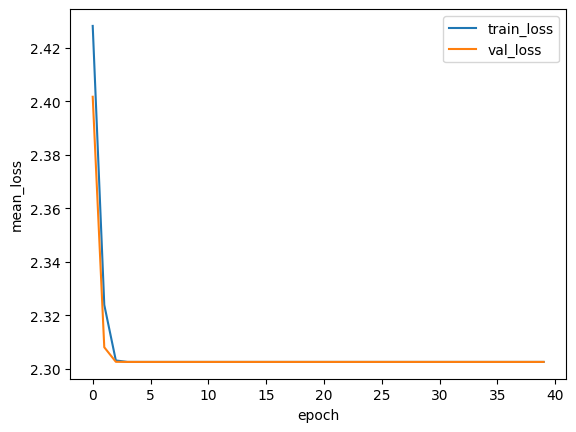

In [23]:
import matplotlib.pyplot as plt
# 训练结果可视化
epochs = range(40)
plt.plot(epochs,loss_train,label = 'train_loss')
plt.plot(epochs,loss_val,label = 'val_loss',)
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.legend()
plt.show()

# 预测标签

In [12]:
def prediction(x,alpha,beta):
    x = np.append(x,1)
    a = linearForward(x,alpha)
    z = sigmoidForward(a)
    b = linearForward(z,beta)
    y_hat = softmaxForward(b)
    pred = y_hat.tolist().index(max(y_hat))
    return pred

In [19]:
# 预测标签测试
label = ['a','e','g','i','l','n','o','r','t','u'] # 序号对应的标签

# 数据读取
import numpy as np
filepath = "data/smallTrain.csv"
X_train,y_train = data_read(filepath) # small train
filepath = "data/smallValidation.csv"
X_val,y_val = data_read(filepath)

for i in range(10):
    pred = prediction(X_val[i],alpha,beta)
    print(pred,y_val[i])

0 5
0 4
0 8
0 7
0 0
0 7
0 3
0 2
0 6
0 1
